In [1]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sparkDF = spark.read.format("com.databricks.spark.csv").options(header='false', inferSchema='true',delimiter='\t').load('/FileStore/tables/sunspots.txt').withColumnRenamed('_c0','id').withColumnRenamed('_c1','Sunspots')
sparkDF.show()
sparkDF.dtypes

+---+--------+
 id|Sunspots|
+---+--------+
 0| 58.0|
 1| 62.6|
 2| 70.0|
 3| 55.7|
 4| 85.0|
 5| 83.5|
 6| 94.8|
 7| 66.3|
 8| 75.9|
 9| 75.5|
 10| 158.6|
 11| 85.2|
 12| 73.3|
 13| 75.9|
 14| 89.2|
 15| 88.3|
 16| 90.0|
 17| 100.0|
 18| 85.4|
 19| 103.0|
+---+--------+
only showing top 20 rows

 Out[ 239 ]: [('id', 'int'), ('Sunspots', 'double')]

In [3]:
vecAssembler = VectorAssembler(inputCols=["Sunspots"], outputCol="features")
df_kmeans = vecAssembler.transform(sparkDF).select('id', 'features')
df_kmeans.show()

+---+--------+
 id|features|
+---+--------+
 0| [58.0]|
 1| [62.6]|
 2| [70.0]|
 3| [55.7]|
 4| [85.0]|
 5| [83.5]|
 6| [94.8]|
 7| [66.3]|
 8| [75.9]|
 9| [75.5]|
 10| [158.6]|
 11| [85.2]|
 12| [73.3]|
 13| [75.9]|
 14| [89.2]|
 15| [88.3]|
 16| [90.0]|
 17| [100.0]|
 18| [85.4]|
 19| [103.0]|
+---+--------+
only showing top 20 rows

In [4]:
cost = np.zeros(20)
# -----looping to find optimal k from 2 to 20 --------------------------
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    #------- taking 0.1 % samples from df_kmeans without replacement to find optimal k -------
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans)

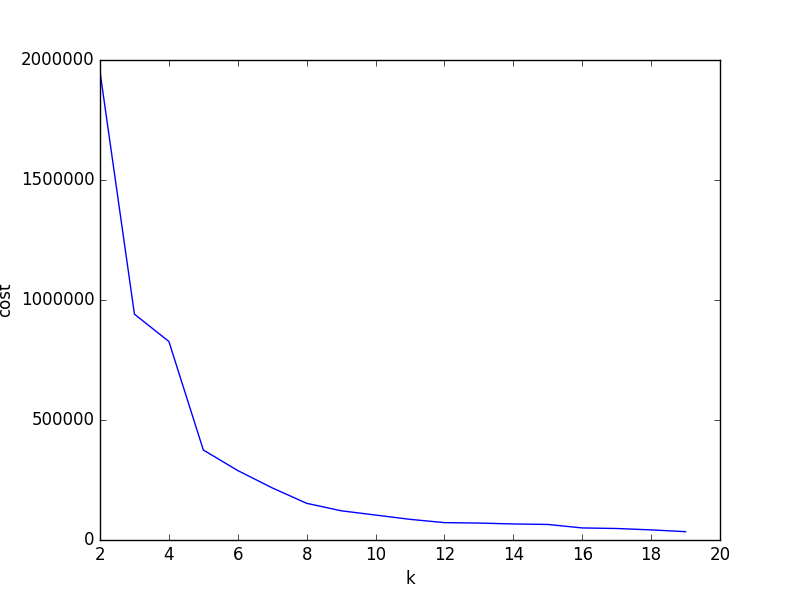

In [5]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
display(fig)

In [6]:
k = 5
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center[0])

Cluster Centers: 
79.4829136691
171.201526718
45.3658482143
12.2649425287
119.860526316

In [7]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
df_pred = sqlContext.createDataFrame(rows)
df_pred = df_pred.join(sparkDF, 'id')
df_pred.show()
#display(transformed)

+---+----------+--------+
 id|prediction|Sunspots|
+---+----------+--------+
 0| 2| 58.0|
 1| 0| 62.6|
 2| 0| 70.0|
 3| 2| 55.7|
 4| 0| 85.0|
 5| 0| 83.5|
 6| 0| 94.8|
 7| 0| 66.3|
 8| 0| 75.9|
 9| 0| 75.5|
 10| 1| 158.6|
 11| 0| 85.2|
 12| 0| 73.3|
 13| 0| 75.9|
 14| 0| 89.2|
 15| 0| 88.3|
 16| 0| 90.0|
 17| 4| 100.0|
 18| 0| 85.4|
 19| 4| 103.0|
+---+----------+--------+
only showing top 20 rows

In [8]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

Out[ 281 ]: 
 prediction Sunspots
id 
0 2 58.0
1 0 62.6
2 0 70.0
3 2 55.7
4 0 85.0

In [9]:
# Outlier detection code, 
class1=np.zeros(pddf_pred.shape[0])
for ind,j in enumerate (pddf_pred.Sunspots):  
    temp=[]
    for i in centers:
        temp.append(np.sqrt(np.square(i-j)))
    if min(temp)<np.mean(pddf_pred['Sunspots']):
        class1[ind]=temp.index(min(temp))
    else:
        class1[ind]=9999

In [10]:
np.unique(class1)

Out[ 292 ]: 
array([ 0.00000000e+00, 1.00000000e+00, 2.00000000e+00,
 3.00000000e+00, 4.00000000e+00, 9.99900000e+03])

In [11]:
pddf_pred['class_predicted_by_us']=class1
pddf_pred

Out[ 284 ]: 
 prediction Sunspots class_predicted_by_us
id 
0 2 58.0 2.0
1 0 62.6 0.0
2 0 70.0 0.0
3 2 55.7 2.0
4 0 85.0 0.0
5 0 83.5 0.0
6 0 94.8 0.0
7 0 66.3 0.0
8 0 75.9 0.0
9 0 75.5 0.0
10 1 158.6 1.0
11 0 85.2 0.0
12 0 73.3 0.0
13 0 75.9 0.0
14 0 89.2 0.0
15 0 88.3 0.0
16 0 90.0 0.0
17 4 100.0 4.0
18 0 85.4 0.0
19 4 103.0 4.0
20 0 91.2 0.0
21 0 65.7 0.0
22 0 63.3 0.0
23 0 75.4 0.0
24 0 70.0 0.0
25 2 43.5 2.0
26 2 45.3 2.0
27 2 56.4 2.0
28 2 60.7 2.0
29 2 50.7 2.0
... ... ... ...
3113 3 3.4 3.0
3114 3 0.8 3.0
3115 3 0.5 3.0
3116 3 1.1 3.0
3117 3 2.9 3.0
3118 3 4.1 3.0
3119 3 0.8 3.0
3120 3 1.3 3.0
3121 3 1.4 3.0
3122 3 0.7 3.0
3123 3 0.8 3.0
3124 3 2.9 3.0
3125 3 2.9 3.0
3126 3 3.2 3.0
3127 3 0.0 3.0
3128 3 4.3 3.0
3129 3 4.8 3.0
3130 3 4.1 3.0
3131 3 10.8 3.0
3132 3 13.2 3.0
3133 3 18.8 3.0
3134 3 15.4 3.0
3135 3 8.0 3.0
3136 3 8.7 3.0
3137 3 13.6 3.0
3138 3 16.1 3.0
3139 3 19.6 3.0
3140 3 25.2 3.0
3141 3 23.5 3.0
3142 3 21.6 3.0

[3143 rows x 3 columns]

In [12]:
classes,count=np.unique(pddf_pred['class_predicted_by_us'], return_counts=True) 
d={"Classes":classes,"count":count}
df = pd.DataFrame(d)
df

Out[ 285 ]: 
 Classes count
0 0.0 558
1 1.0 127
2 2.0 897
3 3.0 1213
4 4.0 344
5 9999.0 4

In [13]:
# finding data points which are outliers
pddf_pred.loc[pddf_pred['class_predicted_by_us'] == 9999]

Out[ 286 ]: 
 prediction Sunspots class_predicted_by_us
id 
352 1 238.9 9999.0
2504 1 235.8 9999.0
2505 1 253.8 9999.0
2507 1 239.4 9999.0